In this notebook, I load the xlsx containing metadata for all the samples, and prune so it only contains samples both present in Alans joint call and the metadata file.
Afterwards, I generate some additional information to add to the metadata.

In [1]:
%run ../scripts/notebook_settings.py

As i only care about the samples present, no calldata fields has to be loaded.
I also note that it is not tabix indexed - the best solution is probably to transform the files into zarr.

In [2]:
meta_data_samples = pd.read_excel("../data/New_Papio.xlsx")

In [3]:
vcf_dir = "/faststorage/project/primatediversity/data/PG_baboons_pananu3_23_2_2021/"
vcf_names = "output.filtered.snps.{}.removed.AB.pass.vep.vcf.gz"
vcf_path = vcf_dir+vcf_names
vcf_callset = allel.read_vcf(vcf_path.format("chrX"), samples=meta_data_samples["PGDP_ID"].tolist())

In [4]:
meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(vcf_callset["samples"])]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
...,...,...,...,...,...,...,...
213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F
214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F
215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F
216,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M


All individuals in the metadata is in, and the ones not in is 9 non-PD samples. I might later add some information, such as callset_index values.
Currently, just only reading in the PD_ individuals should be enough, even though the captive gelada individual probably should be removed.

Now we have reached later, and I a am going to use what I have found in the dp02 to add some extra data per individual

In [26]:
meta_data_samples = pd.read_excel("../data/New_Papio.xlsx")
meta_data_samples = meta_data_samples.loc[meta_data_samples.Origin != "captive"]
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_01_03_2021/callset.zarr/chrX"
callset = zarr.open_group(zarr_dir, mode='r')
gt = allel.GenotypeArray(callset["calldata/GT"])

In [27]:
#Code burrowed from Kasper the make the callset_indexes.
samples_list = list(vcf_callset['samples'][:])
samples_callset_index = [samples_list.index(s) for s in meta_data_samples.PGDP_ID]
meta_data_samples['callset_index'] = samples_callset_index
meta_data_samples

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,callset_index
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,1
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,2
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,3
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,4
5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,5
...,...,...,...,...,...,...,...,...
213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,213
214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,214
215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,215
216,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M,216


There are too many Origins to easily color, so I am going to group some origins

In [28]:
for s in meta_data_samples["Species"].unique():
    print(s)
    s_df = meta_data_samples.loc[meta_data_samples.Species == s]
    print(s_df["Origin"].value_counts())

anubis
Gog Woreda, Gambella region, Ethiopia    25
Lake Manyara, Tanzania                   19
Gombe, Tanzania                          17
Serengeti, Tanzania                      14
Tarangire, Tanzania                       7
Ngorongoro, Tanzania                      6
Arusha, Tanzania                          4
Name: Origin, dtype: int64
cynocephalus
Mikumi, Tanzania         36
Mahale, Tanzania          7
Ruaha, Tanzania           6
Udzungwa, Tanzania        5
Selous, Tanzania          3
Katavi, Tanzania          2
Issa Valley, Tanzania     1
Name: Origin, dtype: int64
papio
Niokolo-Koba, Senegal    12
Name: Origin, dtype: int64
ursinus (grayfoot)
Dendro Park, Zambia    4
Name: Origin, dtype: int64
hamadryas
Filoha, Ethiopia    24
Name: Origin, dtype: int64
kindae
Chunga, Zambia    25
Name: Origin, dtype: int64


Cluster Tarangire, Ngorongoro and Arusha for anubis (Northern Tanzania)
Cluster Mahale, Katavi, Issa Valley (Western Tanzania)
Cluster Ruaha, Udzungwa, Selous (Central Tanzania)

In [29]:
c_origin = []
for i, row in meta_data_samples.iterrows():
    if row.Origin in ["Tarangire, Tanzania", "Ngorongoro, Tanzania", "Arusha, Tanzania"]:
        c_origin.append("Northern Tanzania")
    elif row.Origin in ["Mahale, Tanzania", "Katavi, Tanzania", "Issa Valley, Tanzania"]:
        c_origin.append("Western Tanzania")
    elif row.Origin in ["Ruaha, Tanzania", "Udzungwa, Tanzania", "Selous, Tanzania"]:
        c_origin.append("Central Tanzania")
    else:
        c_origin.append(row.Origin)

In [33]:
meta_data_samples["C_origin"] = c_origin
meta_data_samples.to_csv("../data/metadata_with_clustering.txt", sep = " ", index=False)

See dp02 for more detailed comments on the next part

<AxesSubplot:xlabel='m', ylabel='Count'>

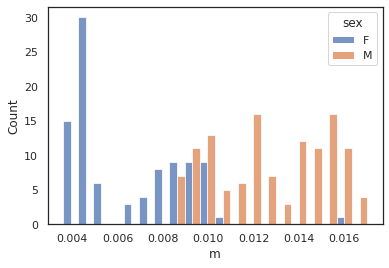

In [34]:
missingness = gt.is_missing()
m_per_i = sum(missingness)
total_sites = len(gt)
d = {"m": m_per_i/total_sites, "ID": meta_data_samples["PGDP_ID"], "sex": meta_data_samples["Sex"]}
m_df = pd.DataFrame(data=d)
sns.histplot(m_df, x="m", hue="sex", multiple="dodge", bins=20)

In [35]:
meta_data_samples["x_missing"] = m_per_i/total_sites
meta_data_samples

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,callset_index,C_origin,x_missing
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,1,"Serengeti, Tanzania",0.003591
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,2,"Serengeti, Tanzania",0.004100
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,3,"Serengeti, Tanzania",0.010000
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,4,"Serengeti, Tanzania",0.010041
5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,5,"Serengeti, Tanzania",0.003674
...,...,...,...,...,...,...,...,...,...,...
213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,213,"Chunga, Zambia",0.009835
214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,214,"Chunga, Zambia",0.009672
215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,215,"Chunga, Zambia",0.010119
216,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M,216,"Chunga, Zambia",0.014323


In [36]:
meta_data_samples.to_csv("../data/metadata_with_x_missing.txt", sep = " ", index=False)